In [12]:
import warnings
warnings.filterwarnings(action='ignore')

import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Activation, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.transform import pyramid_expand
from Subpixel import Subpixel
from DataGenerator import DataGenerator

In [13]:
base_path = r'C:\project\celeba-dataset\processed'

x_train_list = sorted(glob.glob(os.path.join(base_path, 'x_train', '*.npy')))   # x_train폴더에 있는 npy파일들을 불러오는 코드
x_val_list = sorted(glob.glob(os.path.join(base_path, 'x_val', '*.npy')))       # x_val폴더에 있는 npy파일들을 불러오는 코드

print(len(x_train_list), len(x_val_list))
print(x_train_list[7]) 

80270 9965
C:\project\celeba-dataset\processed\x_train\000008.npy


(44, 44, 3) (44, 44, 3)


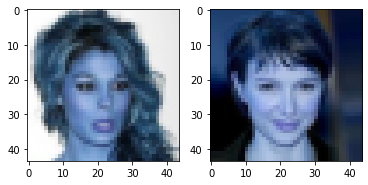

In [19]:
x1 = np.load(x_train_list[5])
x2 = np.load(x_val_list[5])

print(x1.shape, x2.shape)

plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)
plt.show()

In [21]:
# DataGenerator 파라미터들은 DataGenerator.py에 안에 있는 def __init__ 함수 안에 있는 파라미터 사용
train_gen = DataGenerator(list_IDs = x_train_list,
                          labels = None,
                          batch_size = 16,
                          dim = (44,44),
                          n_channels = 3,
                          n_classes = None,
                          shuffle = True)

val_gen = DataGenerator(list_IDs = x_val_list,
                        labels = None,
                        batch_size = 16,
                        dim = (44, 44),
                        n_channels = 3,
                        n_classes = None,
                        shuffle = False)

In [26]:
upscale_factor = 4

inputs = Input(shape=(44, 44, 3))

a = Conv2D(filters=64,
           kernel_size=5,
           strides=1,
           padding='same',
           activation='relu')(inputs)

a = Conv2D(filters=64,
           kernel_size=3,
           strides=1,
           padding='same',
           activation='relu')(a)

a = Conv2D(filters=32,
           kernel_size=3,
           strides=1,
           padding='same',
           activation='relu')(a)

a = Conv2D(filters=16,
           kernel_size=3,
           strides=1,
           padding='same',
           activation='relu')(a)

a = Subpixel(filters=3,
             kernel_size=3,
             r=upscale_factor,
             padding='same')(a)

outputs = LeakyReLU(alpha=0.1)(a)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['mae']) # loss='mse'-> 이미지가 얼마나 같은지, 픽셀 값이 얼마나 같은지 확인하기 위해서 mse사용

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 44, 44, 3)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 44, 44, 32)        18464     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 44, 44, 16)        4624      
_________________________________________________________________
subpixel_4 (Subpixel)        (None, 176, 176, 3)       6960      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 176, 176, 3)      

In [ ]:
history = model.fit_generator(train_gen,
                              validation_data=val_gen,
                              epochs=2,
                              verbose=1,
                              callbacks=[ModelCheckpoint(r'C:\PROJECT\celeba-dataset\models\model.h5')])